# <p align="center">Pattern-CAVs Entanglement Progression Over Layers</p>

In this notebook, we visualize the entanglement progression of Pattern-CAVs along the convolutional layers of VGG16 model trained on the CelebA dataset.

In [1]:
import torch
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

We start by loading the CelebA dataset and neccesary variables.

In [2]:
from datasets import get_dataset

IMG_SIZE = 224
DATASET_NAME = "celeba"
DATASET_DIRS = ["/Users/erogullari/datasets/"]      # change to the directory containing CelebA
SAVE_DIR = "../media/auc_orthogonality_over_layers"

dataset = get_dataset(DATASET_NAME)(data_paths=DATASET_DIRS,
                                    normalize_data=True,
                                    image_size=IMG_SIZE)
concepts = list(dataset.sample_ids_by_concept.keys())       # list of concept names
labels = torch.tensor(dataset.attributes.to_numpy(), dtype=torch.float32)   # binary labels tensor

print(f"Number of images in dataset: {len(dataset)}")
print(f"Labels shape: {labels.shape}")
print(f"Number of concepts present: {len(concepts)}")

for i, c in enumerate(concepts):
    print(f"{i:3d}. {c:20s}")

Number of images in dataset: 20260
Labels shape: torch.Size([20260, 40])
Number of concepts present: 40
  0. 5_o_Clock_Shadow    
  1. Arched_Eyebrows     
  2. Attractive          
  3. Bags_Under_Eyes     
  4. Bald                
  5. Bangs               
  6. Big_Lips            
  7. Big_Nose            
  8. Black_Hair          
  9. Blond_Hair          
 10. Blurry              
 11. Brown_Hair          
 12. Bushy_Eyebrows      
 13. Chubby              
 14. Double_Chin         
 15. Eyeglasses          
 16. Goatee              
 17. Gray_Hair           
 18. Heavy_Makeup        
 19. High_Cheekbones     
 20. Male                
 21. Mouth_Slightly_Open 
 22. Mustache            
 23. Narrow_Eyes         
 24. No_Beard            
 25. Oval_Face           
 26. Pale_Skin           
 27. Pointy_Nose         
 28. Receding_Hairline   
 29. Rosy_Cheeks         
 30. Sideburns           
 31. Smiling             
 32. Straight_Hair       
 33. Wavy_Hair           
 34. Wearing

Then, let's download the weights for the VGG16 model. Alternatively, the weights can be found [here](https://drive.google.com/drive/folders/1Vv_Dq-1hDcYl-A-TuXNH8jRDKe9-BR-k?usp=sharing) under checkpoints.

In [3]:
# !wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1L7O838TRldaWQkGKIFGvwxVe_agnyFAn' -O checkpoint_vgg16_celeba.pth
# !mv checkpoint_vgg16_celeba.pth ../checkpoints/

In [4]:
from models import get_fn_model_loader

MODEL_NAME = "vgg16"
N_CLASSES = 2
CHECKPT_PATH = "../checkpoints/checkpoint_vgg16_celeba.pth"

model = get_fn_model_loader(model_name=MODEL_NAME)(n_class=N_CLASSES, ckpt_path=CHECKPT_PATH)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Now, we can compute the activations at each convolution layer of the VGG16 model.

In [5]:
# Helper fn to compute activations on a given layer of the network.
def get_features(batch, layer_names, attribution, cav_mode="max", device="cpu"):
    batch.requires_grad = True
    dummy_cond = [{"y": 0} for _ in range(len(batch))]
    attr = attribution(batch.to(device), dummy_cond, record_layer=layer_names)
    if cav_mode == "full":
        activations = attr.activations
    if cav_mode == "max":
        activations = {}
        for layer_name in layer_names:
            activations[layer_name] = attr.activations[layer_name].flatten(start_dim=2).max(2)[0]
    return activations

In [6]:
from crp.attribution import CondAttribution
from torch.utils.data import DataLoader

LAYER_IDS = [0, 2, 5, 7, 10, 12, 14, 17, 19, 21, 24, 26, 28]  # VGG16 Convolutional layers
LAYERS = [f"features.{layer_id}" for layer_id in LAYER_IDS]

# File path to save/load latent variables
folder_path = "../variables/latents_celeba_vgg16"
device = 'mps'      # Change to your device

if False:    # Set this to False after running once.
    attribution = CondAttribution(model.to(device))
    # Check if the latent variables have been precomputed and saved
    if not os.path.exists(folder_path):
        os.makedirs(folder_path, exist_ok=True)

    # Compute latent embeddings
    BATCH_SIZE = 16
    CAV_MODE = "max"
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    x_latent_all = {}
    for x, y in tqdm(dataloader):
        activations = get_features(x, LAYERS, attribution, CAV_MODE, device=device)
        for layer_name, x_latent in activations.items():
            if layer_name not in x_latent_all:
                x_latent_all[layer_name] = []
            x_latent = x_latent.detach().cpu()
            x_latent_all[layer_name].append(x_latent)

    # Concatenate and save all latent variables for each layer
    for layer_name in x_latent_all:
        x_latent_all[layer_name] = torch.cat(x_latent_all[layer_name], dim=0)
        latent_file_path = os.path.join(folder_path, f"{layer_name}.pth")
        if not os.path.exists(latent_file_path):
            os.makedirs(os.path.dirname(latent_file_path), exist_ok=True)
        torch.save(x_latent_all[layer_name], latent_file_path)
        print(f"Computed and saved latent variables for {layer_name} to {latent_file_path} (shape: {x_latent_all[layer_name].shape})")

And compute the CAVs at each convolution layer.

In [7]:
from utils.cav import compute_cavs

folder_path = "../variables/latents_celeba_vgg16"
cavs_original = {}

size = len(dataset)
shuffled_ids = torch.randperm(size)
train_ids = shuffled_ids[:int(0.8 * size)]
test_ids = shuffled_ids[int(0.8 * size):]

# Baseline CAVs
for layer in LAYERS:
    latent_file_path = os.path.join(folder_path, f"{layer}.pth")
    if os.path.exists(latent_file_path):
        latents_train = torch.load(latent_file_path)[train_ids]
        labels_train = labels[train_ids]
    else:
        raise FileNotFoundError(f"Latent file for {layer} not found at {latent_file_path}")
    
    cavs_original[layer], _ = compute_cavs(latents_train, labels_train, "pattern_cav")
    print(f"Computed CAVs for {layer} with shape: {cavs_original[layer].shape}")

Computed CAVs for features.0 with shape: torch.Size([40, 64])
Computed CAVs for features.2 with shape: torch.Size([40, 64])
Computed CAVs for features.5 with shape: torch.Size([40, 128])
Computed CAVs for features.7 with shape: torch.Size([40, 128])
Computed CAVs for features.10 with shape: torch.Size([40, 256])
Computed CAVs for features.12 with shape: torch.Size([40, 256])
Computed CAVs for features.14 with shape: torch.Size([40, 256])
Computed CAVs for features.17 with shape: torch.Size([40, 512])
Computed CAVs for features.19 with shape: torch.Size([40, 512])
Computed CAVs for features.21 with shape: torch.Size([40, 512])
Computed CAVs for features.24 with shape: torch.Size([40, 512])
Computed CAVs for features.26 with shape: torch.Size([40, 512])
Computed CAVs for features.28 with shape: torch.Size([40, 512])


Finally we can compute the AUC and Orthogonality scores.

In [8]:
from utils.metrics import get_uniqueness, compute_auc_performance

folder_path = "../variables/latents_celeba_vgg16"

uniqueness_vals = {}
auc_vals = {}
for layer in LAYERS:
    latent_file_path = os.path.join(folder_path, f"{layer}.pth")
    if os.path.exists(latent_file_path):
        latents_test = torch.load(latent_file_path, weights_only=True)[test_ids]
        labels_test = labels[test_ids]
    else:
        raise FileNotFoundError(f"Latent file for {layer} not found at {latent_file_path}")
    
    # Compute uniqueness and AUC for each layer
    uniqueness_vals[layer] = get_uniqueness(cavs_original[layer])
    auc_vals[layer] = compute_auc_performance(cavs_original[layer], latents_test, labels_test)
    print(f"Computed uniqueness and AUC for {layer}.")

uniqueness_vals[LAYERS[0]].shape, auc_vals[LAYERS[0]].shape

Computed uniqueness and AUC for features.0.
Computed uniqueness and AUC for features.2.
Computed uniqueness and AUC for features.5.
Computed uniqueness and AUC for features.7.
Computed uniqueness and AUC for features.10.
Computed uniqueness and AUC for features.12.
Computed uniqueness and AUC for features.14.
Computed uniqueness and AUC for features.17.
Computed uniqueness and AUC for features.19.
Computed uniqueness and AUC for features.21.
Computed uniqueness and AUC for features.24.
Computed uniqueness and AUC for features.26.
Computed uniqueness and AUC for features.28.


((40,), (40,))

## Global AUC vs Orthogonality Over Layers

First, we have an overview of global averages of AUC and Orthogonality of all CAVs at each layer.

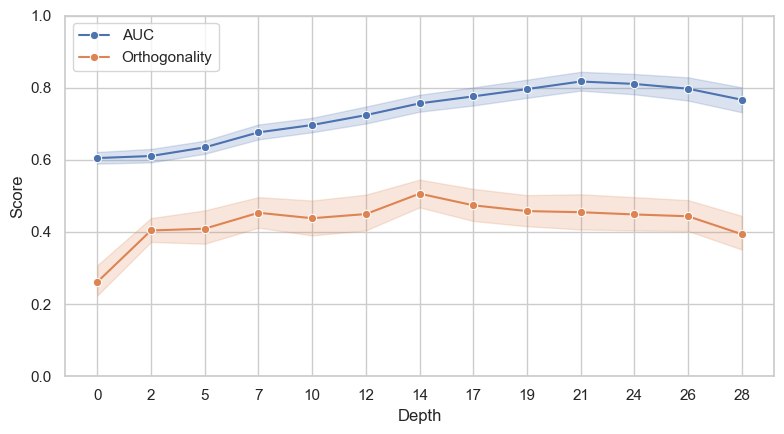

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

records = []
for depth in LAYERS:
    # AUC values for this layer
    for v in np.asarray(auc_vals[depth]).ravel():
        records.append({"depth": depth, "metric": "AUC", "value": float(v)})
    # Orthogonality values for this layer
    for v in np.asarray(uniqueness_vals[depth]).ravel():
        records.append({"depth": depth, "metric": "Orthogonality", "value": float(v)})

df = pd.DataFrame(records)
df["depth"] = pd.Categorical(df["depth"], categories=LAYERS, ordered=True)

plt.figure(figsize=(8, 4.5))
sns.set_theme(style="whitegrid")
sns.lineplot(
    data=df,
    x="depth",
    y="value",
    hue="metric",
    estimator="mean",
    errorbar=("ci", 95),   # seaborn >= 0.12; for older versions use ci=95
    marker="o"
)
plt.xlabel("Depth")
plt.ylabel("Score")
plt.ylim(0, 1)  # unify scale
plt.legend(title="", loc="upper left")
plt.xticks(ticks=range(len(LAYERS)),
           labels=[s.split('.', 1)[1] for s in LAYERS])
plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/global.pdf", format="pdf")
plt.show()

## Individual AUC vs Orthogonality Over Layers

And we can look at indicviual concepts - saved in 'media/auc_orthogonality_over_layers'

In [10]:
for batch_id in range(10):   # Change range for different batches of concepts
    indices_to_plot = list(range(batch_id*4, batch_id*4 + 4)) 

    # Plot 4 concepts AUC and Orthogonality over all layers on a 2x2 grid
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))

    auc_plots = [None] * len(indices_to_plot)
    orthogonality_plots = [None] * len(indices_to_plot)

    for i, idx in enumerate(indices_to_plot):
        auc_plots[i] = [auc_vals[layer][idx] for layer in LAYERS]
        orthogonality_plots[i] = [uniqueness_vals[layer][idx] for layer in LAYERS]

    for idx, ax in enumerate(axes.flatten()):
        concept = concepts[indices_to_plot[idx]]

        # Plot both lines on the same axis
        ax.plot(LAYERS, auc_plots[idx], color='b', marker='o', label='AUC')
        ax.plot(LAYERS, orthogonality_plots[idx], color='orange', marker='o',label='Orthogonality')

        ax.set_title(f'Concept: {concept}')
        ax.set_xlabel('Layer')
        ax.set_ylabel('Value')
        ax.set_ylim(0, 1)  # unify scale
        ax.set_xticks(range(len(LAYERS)))
        ax.set_xticklabels([s.split('.', 1)[1] for s in LAYERS])

        # Single legend
        ax.legend(loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{SAVE_DIR}/concepts_batch_{batch_id}.pdf", format="pdf")
    plt.close()

## Grouped AUC vs Orthogonality Over Layers

We can also group concepts by their complexity and visualize the group aggregations.

In [11]:
group_indices = {
    "simple": {
        "hair_color" : [8, 9, 11, 17],               # Black_Hair, Blond_Hair, Brown_Hair, Gray_Hair
        # "skin_makeup" : [26, 29, 36],                # Pale_Skin, Rosy_Cheeks, Wearing_Lipstick
        # "hair_style" : [4, 5, 32, 33],               # Bald, Bangs, Straight_Hair, Wavy_Hair
        # "accessories" : [15, 34, 35, 37, 38],        # Eyeglasses, Earrings, Hat, Necklace, Necktie
        # "artifact" : [10],                         # Blurry
    },
    "mid": {
        # "facial_hair" : [0, 16, 22, 30, 24],         # 5_o_Clock_Shadow, Goatee, Mustache, Sideburns, No_Beard
        # "eyebrows_eyes" : [1, 12, 23, 3],            # Arched_Eyebrows, Bushy_Eyebrows, Narrow_Eyes, Bags_Under_Eyes
        # "mouth_nose" : [6, 7, 21, 27],               # Big_Lips, Big_Nose, Mouth_Slightly_Open, Pointy_Nose
        "face_shape" : [13, 14, 25, 28, 19],         # Chubby, Double_Chin, Oval_Face, Receding_Hairline, High_Cheekbones
    },
    "complex": {
        "demographics" : [20, 39],                   # Male, Young
        # "style_aesthetics" : [18, 2, 31],            # Heavy_Makeup, Attractive, Smiling
    }
}

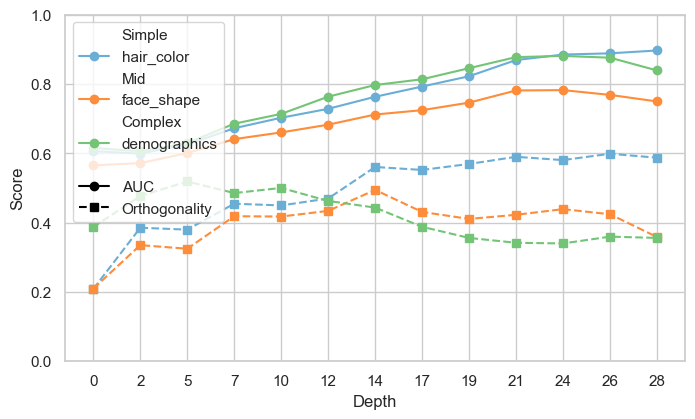

In [15]:
from matplotlib.lines import Line2D

category_to_subgroups = {
    "simple": list(group_indices["simple"].keys()),
    "mid":    list(group_indices["mid"].keys()),
    "complex":list(group_indices["complex"].keys()),
}

# --- 2) Build palettes: one hue per category, different shades for its subgroups ---
category_palettes = {
    "simple":  sns.color_palette("Blues",  n_colors=len(category_to_subgroups["simple"])),
    "mid":     sns.color_palette("Oranges", n_colors=len(category_to_subgroups["mid"])),
    "complex": sns.color_palette("Greens",    n_colors=len(category_to_subgroups["complex"])),
}

# Subgroup → color lookup
subgroup_color = {}
for cat in ["simple", "mid", "complex"]:
    for i, subgroup in enumerate(category_to_subgroups[cat]):
        subgroup_color[(cat, subgroup)] = category_palettes[cat][i]

# --- 3) Compute metrics per *subgroup* (not aggregated over the whole category) ---
subgroup_metrics = {}  # keys: (category, subgroup) -> dict with "AUC" and "Orthogonality" trajectories
for cat, subdict in group_indices.items():
    for subgroup, idxs in subdict.items():
        idxs = np.asarray(idxs, dtype=int)
        auc_traj  = [float(np.asarray(auc_vals[layer])[idxs].mean())          for layer in LAYERS]
        orth_traj = [float(np.asarray(uniqueness_vals[layer])[idxs].mean())   for layer in LAYERS]
        subgroup_metrics[(cat, subgroup)] = {"AUC": auc_traj, "Orthogonality": orth_traj}

# --- 4) Plot: same axes, two linestyles, color by category hue / subgroup shade ---
sns.set_theme(style="whitegrid")
linestyles = {"AUC": "-", "Orthogonality": "--"}
markers     = {"AUC": "o", "Orthogonality": "s"}

fig, ax = plt.subplots(figsize=(8, 4.5))

# Plot in category order, then subgroup order (so legend looks tidy)
for cat in ["simple", "mid", "complex"]:
    for subgroup in category_to_subgroups[cat]:
        color = subgroup_color[(cat, subgroup)]
        m = subgroup_metrics[(cat, subgroup)]

        ax.plot(
            LAYERS, m["AUC"],
            color=color, linestyle=linestyles["AUC"], marker=markers["AUC"],
            label=f"{subgroup} (AUC)"
        )
        ax.plot(
            LAYERS, m["Orthogonality"],
            color=color, linestyle=linestyles["Orthogonality"], marker=markers["Orthogonality"],
            label=f"{subgroup} (Orth)"
        )

# --- 5) Axes formatting ---
ax.set_xlabel("Depth")
ax.set_ylabel("Score")
ax.set_ylim(0, 1)
ax.set_xticks(range(len(LAYERS)))
ax.set_xticklabels([s.split('.', 1)[1] for s in LAYERS])

# --- 6) Build a grouped legend: category headers + subgroup entries + linestyle key ---
# Header handles (invisible lines used as headings)
header_handles = [
    Line2D([0], [0], color="none", label="Simple",  linewidth=0),
    Line2D([0], [0], color="none", label="Mid",     linewidth=0),
    Line2D([0], [0], color="none", label="Complex", linewidth=0),
]

# Subgroup handles (colored) — just one handle per subgroup (AUC style)
subgroup_handles = []
for cat in ["simple", "mid", "complex"]:
    # add a header marker, then the subgroups
    subgroup_handles.append(Line2D([], [], color="none", label=cat.capitalize()))
    for subgroup in category_to_subgroups[cat]:
        color = subgroup_color[(cat, subgroup)]
        subgroup_handles.append(
            Line2D([0], [0], color=color, linestyle=linestyles["AUC"], marker=markers["AUC"], label=subgroup)
        )

# Linestyle key (monochrome) to explain AUC vs Orthogonality
style_handles = [
    Line2D([0], [0], color="black", linestyle=linestyles["AUC"], marker=markers["AUC"], label="AUC"),
    Line2D([0], [0], color="black", linestyle=linestyles["Orthogonality"], marker=markers["Orthogonality"], label="Orthogonality"),
]

# Compose final legend handles (category headers + subgroups + style key)
# (We already added a text header before each category's subgroups above.)
legend_handles = subgroup_handles + [Line2D([], [], color="none", label=""), *style_handles]

ax.legend(
    handles=legend_handles,
    #title="Groups (color) and Metrics (linestyle)",
    loc="upper left", 
    # bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

# fig.tight_layout(rect=(0, 0, 0.80, 1))

SAVE_DIR = "../media/auc_orthogonality_over_layers"

os.makedirs(f"{SAVE_DIR}", exist_ok=True)
plt.savefig(f"{SAVE_DIR}/concept_groups.pdf", format="pdf")
plt.show()